In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

### 淘宝用户行为分析
数据源来自阿里天池公开的一个淘宝用户行为数据集，包含了2017-11-25至2017-12-03之间的有行为的约100万随机用户的用户行为(包括点击pv、购买buy、加购cart、收藏fav)。总的数据量约有1个亿，因此随机选取了约2000名用户进行分析。

In [9]:
def read_part_data(file1,dile2):
    with open(file1,'r') as f1:
        with open(file2,'w') as f2:
            a = set()
            for line in f1:
                a.add(list(line.split(','))[0])
            userlist = random.sample(a,2000)
            f1.seek(0)
            for line in f1:
                if list(line.split(','))[0] in userlist:
                    f2.write(line)
file1 = 'D:/DataSet/0201-taobao1920/UserBehavior.csv'
file2 = 'D:/DataSet/0201-taobao1920/UserBehavior_samplit.csv'
read_part_data(file1,file2)

In [2]:
sampling_data = pd.read_csv('D:/DataSet/0201-taobao1920/UserBehavior_samplit.csv')
sampling_data.columns=['user_id','item_id','item_category','behavior_type','dt_time']

1.数据概况

In [3]:
# 查看数据
sampling_data.head()    

,user_id,item_id,item_category,behavior_type,dt_time
0,1000105,1286327,1859277,pv,1511615524
1,1000105,847992,2920476,pv,1511785029
2,1000105,4871356,381850,pv,1511787514
3,1000105,4875283,2920476,pv,1511969026
4,1000105,1286327,1859277,pv,1511969051


数据集中的每一行代表一个用户行为，由用户id,商品id,商品种类id,行为类型,时间戳构成

In [4]:
sampling_data.info()
# 可以看到数据集没有缺失情况

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199973 entries, 0 to 199972
Data columns (total 5 columns):
user_id          199973 non-null int64
item_id          199973 non-null int64
item_category    199973 non-null int64
behavior_type    199973 non-null object
dt_time          199973 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.6+ MB


2.数据清洗

In [5]:
# 去除重复值
sampling_data = sampling_data.drop_duplicates()
# 异常值检查
sampling_data.describe()

,user_id,item_id,item_category,dt_time
count,1.999700e+05,1.999700e+05,1.999700e+05,1.999700e+05
mean,5.042464e+05,2.580796e+06,2.720923e+06,1.511959e+09
std,2.971190e+05,1.488413e+06,1.443681e+06,2.322688e+05
min,7.660000e+02,8.100000e+01,2.171000e+03,1.509605e+09
25%,2.318070e+05,1.299550e+06,1.397912e+06,1.511759e+09
50%,5.171390e+05,2.583636e+06,2.735466e+06,1.511963e+09
75%,7.654460e+05,3.868902e+06,4.145813e+06,1.512180e+09
max,1.017792e+06,5.163057e+06,5.161669e+06,1.512318e+09


In [69]:
sampling_data['behavior_type'].unique()

array(['pv', 'cart', 'fav', 'buy'], dtype=object)

In [6]:
# 将时间戳转化为YYYY-mm-dd HH:MM:SS 格式
import time
time_Array = []
for dt in sampling_data['dt_time']:
    timeArray = time.localtime(dt)
    otherStyleTime = time.strftime("%Y-%m-%d %H:%M:%S", timeArray)
    time_Array.append(otherStyleTime)
sampling_data['date_time'] = time_Array
sampling_data['date'] = sampling_data['date_time'].map(lambda s: s.split(' ')[0])
sampling_data['date'] = pd.to_datetime(sampling_data['date'])
sampling_data['hour'] = sampling_data['date_time'].map(lambda s: s.split(' ')[1])

In [7]:
sampling_data.head()

,user_id,item_id,item_category,behavior_type,dt_time,date_time,date,hour
0,1000105,1286327,1859277,pv,1511615524,2017-11-25 21:12:04,2017-11-25,21:12:04
1,1000105,847992,2920476,pv,1511785029,2017-11-27 20:17:09,2017-11-27,20:17:09
2,1000105,4871356,381850,pv,1511787514,2017-11-27 20:58:34,2017-11-27,20:58:34
3,1000105,4875283,2920476,pv,1511969026,2017-11-29 23:23:46,2017-11-29,23:23:46
4,1000105,1286327,1859277,pv,1511969051,2017-11-29 23:24:11,2017-11-29,23:24:11


In [8]:
sampling_data.date.min()              # 2017-11-02
sampling_data.date.max()              # 2017-12-04
date_test = sampling_data.groupby('date')['user_id'].count()
date_test

date
2017-11-02        2
2017-11-16        3
2017-11-17        1
2017-11-18        1
2017-11-19        1
2017-11-22        4
2017-11-23        6
2017-11-24       98
2017-11-25    21925
2017-11-26    21590
2017-11-27    19551
2017-11-28    20225
2017-11-29    20021
2017-11-30    20280
2017-12-01    21139
2017-12-02    27278
2017-12-03    27825
2017-12-04       20
Name: user_id, dtype: int64

可以看到有一些异常日期数据

In [9]:
# 剔除异常值
data = sampling_data[(sampling_data['date']>='2017-11-25')&(sampling_data['date']<='2017-12-03')]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199834 entries, 0 to 199972
Data columns (total 8 columns):
user_id          199834 non-null int64
item_id          199834 non-null int64
item_category    199834 non-null int64
behavior_type    199834 non-null object
dt_time          199834 non-null int64
date_time        199834 non-null object
date             199834 non-null datetime64[ns]
hour             199834 non-null object
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 13.7+ MB


3.用户行为分析

In [82]:
# 数据的基本属性
len(data['item_id'].unique())        # 116004件商品
len(data['item_category'].unique())  # 3875种类别

3875

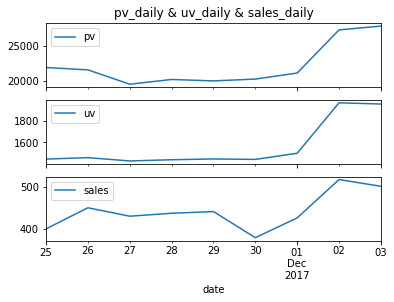

In [85]:
# 日访问量分析
# 日浏览量pv_daily
pv_daily = data.groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})
# 日活跃用户量uv_daily
uv_daily = data.groupby('date')['user_id'].apply(lambda x:x.drop_duplicates().count()).reset_index().rename(columns={'user_id':'uv'})
# 日销量sales_daily
sales_daily = data[data['behavior_type'] == 'buy'].groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'sales'})

fig,axes = plt.subplots(3,1,sharex = True)
pv_daily.plot(x = 'date',y = 'pv',ax = axes[0])
uv_daily.plot(x = 'date',y = 'uv',ax = axes[1])
sales_daily.plot(x = 'date',y = 'sales',ax = axes[2])
axes[0].set_title('pv_daily & uv_daily & sales_daily')

25日-1日这一周来说趋势是相对平稳的，25、26周末两天访问量较高，工作日下降。到2号3号整体的访问量、活跃用户量、销售量都有明显增长，猜测是双十二预热活动开始？

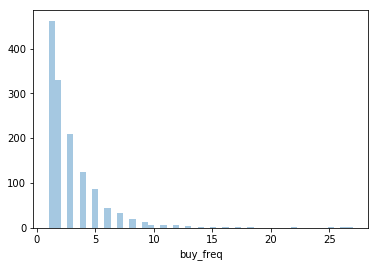

In [89]:
# 用户消费行为
user_buy = data[data['behavior_type']=='buy'].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id':'buy_freq'})
sns.distplot(user_buy['buy_freq'],kde=False)
plt.show()

可以看到，大部分用户消费次数在10次(9天),因此可以重点关注下消费次数大于10次的用户

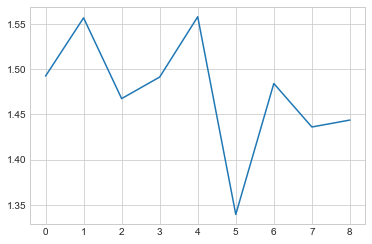

In [96]:
# 每天的人均消费次数(消费总次数/消费人数)
buy_freq_daily = data[data['behavior_type']=='buy'].groupby('date')['user_id'].apply(lambda x:x.count()/len(x.unique())).reset_index().rename(columns={'user_id':'buy_rate'})
sns.set_style('whitegrid')
plt.plot(buy_freq_daily['buy_rate'])
plt.show()

每天的人均消费次数大概在1.5上下波动

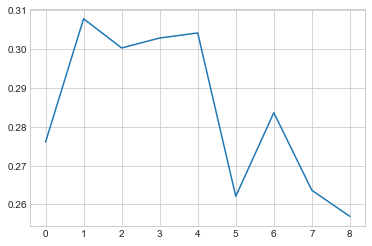

In [98]:
# 活跃用户的平均消费次数(总消费次数/活跃用户人数)
buy_freq_daily2 = data.groupby('date')['user_id','behavior_type'].apply(lambda x:x[x['behavior_type']=='buy'].count()/len(x.user_id.unique())).reset_index().rename(columns={'user_id':'buy_rate2'})
sns.set_style('whitegrid')
plt.plot(buy_freq_daily2['buy_rate2'])
plt.show()

活跃用户日平均消费次数只有0.3左右，并且周末整体偏低

In [100]:
# 消费次数top10的用户
user_top10 = data[data['behavior_type']=='buy'].groupby('user_id')['item_id'].count().sort_values(ascending=False)
user_top10.head(10)

user_id
497950     27
137404     26
1014293    25
604941     22
150920     18
591591     17
139221     17
765446     16
784091     15
373829     15
Name: item_id, dtype: int64

In [107]:
# 可以看下消费最高的这个用户的消费行为
user1 = data[data['user_id']==497950]
user1_item = user1[user1['behavior_type']=='buy'].groupby('item_id')['user_id'].count().sort_values(ascending=False)
user1_item.head()

item_id
4851791    1
2110059    1
315280     1
320123     1
358275     1
Name: user_id, dtype: int64

In [108]:
user1_category = user1[user1['behavior_type']=='buy'].groupby('item_category')['user_id'].count().sort_values(ascending=False)
user1_category.head()

item_category
4357323    9
4217906    2
3299155    2
2939262    2
4284875    1
Name: user_id, dtype: int64

从商品id上看不出什么，商品种类上看该用户偏爱买4357323这类商品。

In [109]:
# 还可以看下消费时间间隔、转化率等
user1_analysis = user1.groupby('behavior_type')['item_id'].count()
user1_analysis

behavior_type
buy      27
cart      5
fav      13
pv      136
Name: item_id, dtype: int64

这个用户浏览了136件商品，最终购买了27件，转化率还是很高的。

In [111]:
# 用户整体转化率
user_pv = data.groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id':'pv'})
user_cart = data[data['behavior_type']=='cart'].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id':'cart'})
user_fav = data[data['behavior_type']=='fav'].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id':'fav'})
user_buy = data[data['behavior_type']=='buy'].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id':'buy'})
user_behavior = pd.merge(user_pv,user_cart,on='user_id')
user_behavior = pd.merge(user_behavior,user_fav,on='user_id')
user_behavior = pd.merge(user_behavior,user_buy,on='user_id')
user_behavior['pv_cart_rate'] = user_behavior['cart']/user_behavior['pv']
user_behavior['pv_fav_rate'] = user_behavior['fav']/user_behavior['pv']
user_behavior['pv_buy_rate'] = user_behavior['buy']/user_behavior['pv']
user_behavior.sort_values(by='pv_buy_rate',ascending=False).head()

,user_id,pv,cart,fav,buy,pv_cart_rate,pv_fav_rate,pv_buy_rate
103,207940,14,1,2,6,0.071429,0.142857,0.428571
355,836519,30,1,1,10,0.033333,0.033333,0.333333
68,137404,145,10,2,26,0.068966,0.013793,0.179310
71,139221,100,4,4,17,0.040000,0.040000,0.170000
202,485844,30,2,1,5,0.066667,0.033333,0.166667


4.商品分析

In [112]:
# 销量最高的商品
item_top10 = data[data['behavior_type']=='buy'].groupby('item_id')['user_id'].count().sort_values(ascending=False)
item_top10.head()

item_id
3189426    5
2290584    5
265942     5
705557     4
3312811    4
Name: user_id, dtype: int64

In [113]:
# 销量最高的商品类别
item_category_top10 = data[data['behavior_type']=='buy'].groupby('item_category')['user_id'].count().sort_values(ascending=False)
item_category_top10.head()

item_category
2735466    83
1464116    68
2885642    65
4756105    54
4145813    52
Name: user_id, dtype: int64

由于商品种类比较多，这里样本选取不够多，销量最高的商品也只销售了5个。

关联性分析

这里主要做的商品类别之间的关联分析

In [73]:
# --*-- encoding:utf-8 --*--
'''aprior算法'''

def createC1(dataset):
    '''创建初始候选集'''
    print('正在创建初始候选集')
    c1 = set()
    for items in dataset:
        for item in items:
            item_set = frozenset([item])
            c1.add(item_set)
    return c1

def generate_freq_support(dataset,itemset,minsupport):
    '''寻找频繁项集，并计算支持度'''
    print('寻找频繁项集，并计算支持度')
    freq_set = set()      # 保存频繁项集元素
    item_count = {}       # 保存频次
    supports = {}         # 保存支持度
    
    # 计算频次
    for data in dataset:
        for item in itemset:
            if item.issubset(data):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1
    data_len = float(len(dataset))
    # 计算支持度
    for item in item_count:
        if (item_count[item]/data_len) >= minsupport:
            freq_set.add(item)
            supports[item] = item_count[item]/data_len
    return freq_set,supports

def generate_new_itemset(freq_set,k):
    '''根据频繁项集，生成新的候选集'''
    print('根据频繁项集，生成新的候选集')
    new_itemset = set()    # 保存新的候选集
    sets_len = len(freq_set)
    freq_set_list = list(freq_set)   # 将集合转为列表，便于索引
    
    for i in range(sets_len):
        for j in range(i+1,sets_len):
            l1 = list(freq_set_list[i])
            l2 = list(freq_set_list[j])
            l1.sort()
            l2.sort()
            
            # 若两个集合的前k-2个项相同，则合并
            if l1[0:k-2] == l2[0:k-2]:
                freq_item = freq_set_list[i] | freq_set_list[j]
                new_itemset.add(freq_item)
    return new_itemset
                
def apriori(dataset,minsupport,maxlen=None):
    '''apriori算法，循环生成候选集并计算支持度'''
    print('apriori算法，循环生成候选集并计算支持度')
    max_items = 2         # 初始项集元素个数
    freq_sets = []        # 保存所有频繁项集
    supports = {}          # 保存所有支持度
    
    # 候选1项集
    C1 = createC1(dataset)
    # 频繁1项集及支持度
    l1,support1 = generate_freq_support(dataset,C1,minsupport)
    freq_sets.append(l1)
    supports.update(support1)
    
    if maxlen is None:
        maxlen = float('inf')
        
    # 开始循环
    while max_items and max_items<=maxlen:
        ci = generate_new_itemset(freq_sets[-1],max_items)
        li,support = generate_freq_support(dataset,ci,minsupport)
        
        if li:
            freq_sets.append(li)
            supports.update(support)
            max_items += 1
        else:
            max_items = 0
    return freq_sets,supports

def association_rules(freq_sets,supports,min_conf):
    '''生成关联规则'''
    print('正在生成关联规则')
    rules = []
    max_len = len(freq_sets)
    
    # 筛选符合规则的频繁项集并计算置信度
    for k in range(max_len - 1):
        for freq_set in freq_sets[k]:
            for sub_set in freq_sets[k+1]:
                if freq_set.issubset(sub_set):
                    frq = supports[sub_set]
                    conf = supports[sub_set]/supports[freq_set]
                    for item in freq_sets[0]:
                        if item.issubset(sub_set-freq_set):
                            lift = conf/supports[item]
                    rule = (freq_set,sub_set-freq_set,frq,conf,lift)
                    if conf>= min_conf:
                        print(freq_set,'-->',sub_set-freq_set,'frq:',frq,'conf:',conf,'lift:',lift)
                        rules.append(rule)
    return rules                  

In [53]:
if __name__ == '__main__':
    # 创建测试数据
    dic = {'user_id':[111,111,
                      112,112,112,112,
                      113,113,113,113,
                      114,114,114,114,
                      115,115,115,115],
          'item_id':['豆奶','莴笋',
                    '莴笋','尿布','啤酒','甜菜',
                    '豆奶','尿布','啤酒','橙汁',
                    '莴笋','豆奶','尿布','啤酒',
                    '莴笋','豆奶','尿布','橙汁']}
    data_test = pd.DataFrame(dic)
    
    # 关联规则中不考虑多次购买同一件商品，删除重复项
    data_test = data_test.drop_duplicates()
    
    # 初始化列表
    data_set = []
    # 分组聚合，统一用户购买多次商品的合并为一条数据，只有1件商品的没有意义，需要进行过滤
    groups = data_test.groupby(by='user_id')
    for group in groups:
        if len(group[1])>=2:
            data_set.append(group[1]['item_id'].tolist())
    
    # L 为频繁项集，support_data为支持度
    L_test,support_data_test=apriori(data_set,minsupport=0.5)
    association_rules_test = association_rules(L_test,support_data_test,min_conf=0.7)
    # print('关联规则:\n',association_rules)

apriori算法，循环生成候选集并计算支持度
正在创建初始候选集
寻找频繁项集，并计算支持度
根据频繁项集，生成新的候选集
寻找频繁项集，并计算支持度
根据频繁项集，生成新的候选集
寻找频繁项集，并计算支持度
正在生成关联规则
frozenset({'莴笋'}) --> frozenset({'尿布'}) frq: 0.6 conf: 0.7499999999999999 lift: 0.9374999999999998
frozenset({'莴笋'}) --> frozenset({'豆奶'}) frq: 0.6 conf: 0.7499999999999999 lift: 0.9374999999999998
frozenset({'啤酒'}) --> frozenset({'尿布'}) frq: 0.6 conf: 1.0 lift: 1.25
frozenset({'尿布'}) --> frozenset({'豆奶'}) frq: 0.6 conf: 0.7499999999999999 lift: 0.9374999999999998
frozenset({'尿布'}) --> frozenset({'莴笋'}) frq: 0.6 conf: 0.7499999999999999 lift: 0.9374999999999998
frozenset({'尿布'}) --> frozenset({'啤酒'}) frq: 0.6 conf: 0.7499999999999999 lift: 0.9374999999999998
frozenset({'豆奶'}) --> frozenset({'尿布'}) frq: 0.6 conf: 0.7499999999999999 lift: 0.9374999999999998
frozenset({'豆奶'}) --> frozenset({'莴笋'}) frq: 0.6 conf: 0.7499999999999999 lift: 0.9374999999999998


In [78]:
if __name__ == '__main__':
    # 创建测试数据
    data_taobao = data[['user_id','item_category']]
    
    # 关联规则中不考虑多次购买同一件商品，删除重复项
    data_taobao = data_taobao.drop_duplicates()
    
    # 初始化列表
    data_set = []
    # 分组聚合，统一用户购买多次商品的合并为一条数据，只有1件商品的没有意义，需要进行过滤
    groups = data_taobao.groupby(by='user_id')
    for group in groups:
        if len(group[1])>=2:
            data_set.append(group[1]['item_category'].tolist())
    
    # L 为频繁项集，support_data为支持度
    L,support_data=apriori(data_set,minsupport=0.1)
    association_rules = association_rules(L,support_data,min_conf=0.3)
    # print('关联规则:\n',association_rules)

apriori算法，循环生成候选集并计算支持度
正在创建初始候选集
寻找频繁项集，并计算支持度
根据频繁项集，生成新的候选集
寻找频繁项集，并计算支持度
根据频繁项集，生成新的候选集
寻找频繁项集，并计算支持度
根据频繁项集，生成新的候选集
寻找频繁项集，并计算支持度
根据频繁项集，生成新的候选集
寻找频繁项集，并计算支持度
根据频繁项集，生成新的候选集
寻找频繁项集，并计算支持度
正在生成关联规则
frozenset({1320293}) --> frozenset({4756105}) frq: 0.23223223223223224 conf: 0.6480446927374303 lift: 1.5214962351226624
frozenset({1320293}) --> frozenset({1080785}) frq: 0.15365365365365366 conf: 0.4287709497206704 lift: 1.850290189075377
frozenset({1320293}) --> frozenset({2920476}) frq: 0.12262262262262262 conf: 0.3421787709497207 lift: 1.9645781159699485
frozenset({1320293}) --> frozenset({2465336}) frq: 0.17567567567567569 conf: 0.4902234636871509 lift: 1.7648044692737432
frozenset({1320293}) --> frozenset({4801426}) frq: 0.2037037037037037 conf: 0.5684357541899442 lift: 1.7234213002602556
frozenset({1320293}) --> frozenset({2735466}) frq: 0.16966966966966968 conf: 0.47346368715083803 lift: 1.6713435458080819
frozenset({1320293}) --> frozenset({982926}) frq: 0.2782782782782783 conf

frozenset({4801426, 1320293}) --> frozenset({2465336}) frq: 0.12412412412412413 conf: 0.6093366093366094 lift: 2.193611793611794
frozenset({4801426, 1320293}) --> frozenset({3002561}) frq: 0.1001001001001001 conf: 0.49140049140049147 lift: 1.7690417690417692
frozenset({4801426, 1320293}) --> frozenset({2735466}) frq: 0.11211211211211211 conf: 0.5503685503685504 lift: 1.9428204304529393
frozenset({4801426, 1320293}) --> frozenset({149192}) frq: 0.1036036036036036 conf: 0.5085995085995086 lift: 2.4194805194805196
frozenset({4801426, 1320293}) --> frozenset({2355072}) frq: 0.15015015015015015 conf: 0.7371007371007372 lift: 2.0229770229770234
frozenset({4756105, 3002561}) --> frozenset({1320293}) frq: 0.11461461461461461 conf: 0.6505681818181818 lift: 1.8154123285931945
frozenset({4756105, 3002561}) --> frozenset({3607361}) frq: 0.10960960960960961 conf: 0.6221590909090909 lift: 1.812061025708985
frozenset({4756105, 3002561}) --> frozenset({2465336}) frq: 0.1001001001001001 conf: 0.5681818

frozenset({2465336, 2520377}) --> frozenset({4801426}) frq: 0.11161161161161161 conf: 0.6947040498442368 lift: 2.106249911363862
frozenset({2465336, 2520377}) --> frozenset({982926}) frq: 0.13213213213213212 conf: 0.822429906542056 lift: 1.9821652029807335
frozenset({2465336, 2520377}) --> frozenset({1320293}) frq: 0.11961961961961962 conf: 0.7445482866043615 lift: 2.0776640735132883
frozenset({2465336, 2520377}) --> frozenset({2355072}) frq: 0.12162162162162163 conf: 0.7570093457943926 lift: 2.0776163089247204
frozenset({2355072, 2920476}) --> frozenset({4756105}) frq: 0.1001001001001001 conf: 0.7722007722007723 lift: 1.8129931173409437
frozenset({2355072, 2920476}) --> frozenset({2520377}) frq: 0.1031031031031031 conf: 0.7953667953667953 lift: 2.596638655462185
frozenset({2355072, 2920476}) --> frozenset({1320293}) frq: 0.1001001001001001 conf: 0.7722007722007723 lift: 2.1548284118116525
frozenset({2355072, 2920476}) --> frozenset({982926}) frq: 0.10560560560560561 conf: 0.8146718146

frozenset({3002561, 1320293, 982926}) --> frozenset({4756105}) frq: 0.1001001001001001 conf: 0.7722007722007723 lift: 1.8129931173409437
frozenset({3607361, 1320293, 2520377}) --> frozenset({2355072}) frq: 0.10560560560560561 conf: 0.8473895582329318 lift: 2.325665298556865
frozenset({3607361, 1320293, 2520377}) --> frozenset({982926}) frq: 0.10760760760760761 conf: 0.8634538152610443 lift: 2.0810382664554483
frozenset({3607361, 1320293, 2520377}) --> frozenset({4756105}) frq: 0.1011011011011011 conf: 0.8112449799196787 lift: 1.9046621267679413
frozenset({2355072, 3607361, 1320293}) --> frozenset({4756105}) frq: 0.12012012012012012 conf: 0.7973421926910299 lift: 1.8720208002311136
frozenset({2355072, 3607361, 1320293}) --> frozenset({982926}) frq: 0.13113113113113112 conf: 0.8704318936877076 lift: 2.097856361384849
frozenset({2355072, 3607361, 1320293}) --> frozenset({2520377}) frq: 0.10560560560560561 conf: 0.7009966777408638 lift: 2.2885479773304676
frozenset({2355072, 3607361, 13202

In [79]:
item_list = []
itemset_list = []
support_list = []
for item in support_data:
    item_list.append(item)
    support_list.append(support_data[item])

# 输出结果
# 输出频繁项集
sup = {'item_category':item_list,'support':support_list}
sup = pd.DataFrame(sup)
sup = sup.sort_values(by='support',ascending=False)
sup.to_csv('D:/DataSet/0201-taobao1920/output_item_support.csv',index=False)

# 输出关联关系
rules = pd.DataFrame(association_rules,columns = ['antecedent','consequent','support','confidence','lift']) 
rules.to_csv('D:/DataSet/0201-taobao1920/output_rules.csv')

关联分析结论：

1.从支持度来看，商品种类4756105最受欢迎。

2.所有商品种类组合按支持度从高到低排序，可以看到商品种类组合中982926-->1320293和1320293-->982926的支持度最高，其中1320293-->982926的置信度更高些，这说明购买1320293商品种类的用户中有77%会购买商品种类为982926的物品，可以将两类商品摆在同一片区域。

3.置信度最高的商品组合[2465336,4801426,1320293]-->982926,置信度高达90%，但是出现的概率只有11%。

FP-growth算法